In [1]:

import random as pyrand
from itertools import *
matplotlib.rc("image",cmap="gray")
matplotlib.rc("image",interpolation="nearest")
import tables
hdf = tables.openFile("1k.h5","r")
images = hdf.root.icons
def crop_black(image):
    gray = image
    if gray.ndim==3: gray = sum(image,axis=2)
    yr = find(sum(gray,axis=1)>0)
    y0 = yr[0]
    y1 = yr[-1]
    xr = find(sum(gray,axis=0)>0)
    x0 = xr[0]
    x1 = xr[-1]
    if image.ndim==3: return image[y0:y1,x0:x1,:]
    else: return image[y0:y1,x0:x1]

# Images and Patches

0.0 1.0


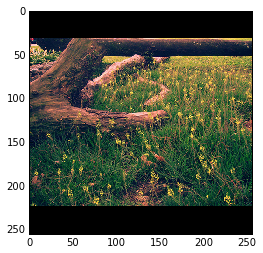

In [2]:
imshow(images[0])
print amin(images[0]),amax(images[0])

Patches:

- small, equal-sized subregions of the image
- usually square
- can be preprocessed / normalized in various ways
- may be extracted uniformly across the image, or at "interest points"

In [3]:
r = 8

def pnorm(p):
    p = mean(p,axis=2)
    #p -= mean(p)
    #p = clip(p/clip(var(p),0.1,10),-2,2)
    #p /= max(1.0,amax(abs(p)))
    return p

def patches(image,r=r):
    image = crop_black(image)
    h,w,d = image.shape
    if amax(image)>2.0: image = image/255.0
    assert d==3
    for y in range(0,h-r,r//2):
        for x in range(0,w-r,r//2):
            patch = pnorm(image[y:y+r,x:x+r].copy())
            yield patch

(8, 8) float32 0.129036 0.512177


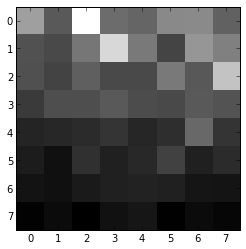

In [4]:
# example patch
sample_patch = list(islice(patches(images[0]),100,101))[0]
print sample_patch.shape,sample_patch.dtype,amin(sample_patch),amax(sample_patch)
imshow(sample_patch+0.5)
pshape = list(sample_patch.shape)

In [5]:
# extract patches across the whole image
data = zeros([70000]+pshape,'f')
i = 0
l = list(images)
shuffle(l)
for image in l:
    for patch in patches(image,r):
        if i>=len(data): break
        data[i] = patch
        i += 1

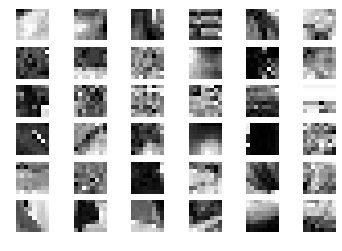

In [6]:
# example patches displayed
for i,patch in enumerate(pyrand.sample(data,36)):
    subplot(6,6,i+1); axis("off"); imshow(clip(patch,0,1))

In [7]:
# perform k-means clustering to create a shape inventory
from sklearn.cluster import MiniBatchKMeans
km = MiniBatchKMeans(1024)
km.fit(data.reshape(len(data),-1))

/usr/lib/pymodules/python2.7/sklearn/cluster/k_means_.py:1180: RuntimeWarning: init_size=300 should be larger than k=1024. Setting it to 3*k
  init_size=init_size)


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, k=None, max_iter=100, max_no_improvement=10,
        n_clusters=1024, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

0.0 1.0


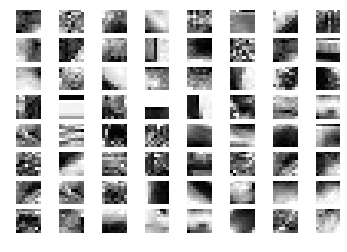

In [8]:
print amin(km.cluster_centers_),amax(km.cluster_centers_)
for i,image in enumerate(km.cluster_centers_[:64]):
    subplot(8,8,i+1); axis("off"); imshow(image.reshape(*pshape)/max(amax(image),1.0))

# VQ Compression

In [9]:
def patchcode(image,r=r):
    image = crop_black(image)
    if amax(image)>2.0: image = image/255.0
    h,w,d = image.shape
    if len(pshape)==2: result = zeros(image.shape[:2])
    else: result = zeros(list(image.shape[:2])+[3])
    for y in range(0,h-r,r):
        for x in range(0,w-r,r):
            if i>=len(data): break
            patch = image[y:y+r,x:x+r]
            patch = pnorm(patch)
            code = km.predict(patch.reshape(1,-1))[0]
            result[y:y+r,x:x+r] = km.cluster_centers_[code].reshape(*pshape)
    return result

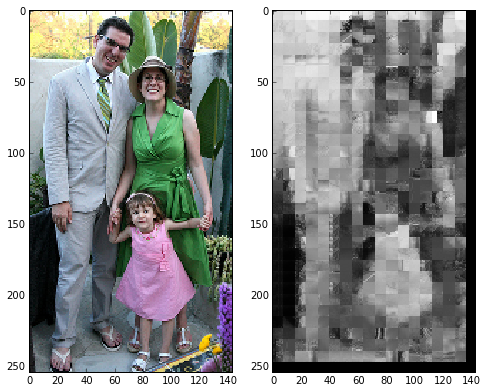

In [14]:
figsize(8,8)
subplot(121); imshow(crop_black(images[1]))
subplot(122); imshow(patchcode(images[1]))

# VQ Code Histograms as Image Descriptors

In [12]:
from collections import Counter
def patchhist(image):
    data = array([patch for patch in patches(image)])
    codes = km.predict(data.reshape(len(data),-1))
    result = zeros(len(km.cluster_centers_))
    for k,v in Counter(codes).items(): result[k] = v
    return result
patchhist(images[0])

array([  2.,   5.,  10., ...,   0.,   0.,   0.])

In [13]:
phs = [patchhist(image) for image in images]

In [ ]:
from scipy.spatial.distance import cdist
dists = cdist(phs,phs,metric='cosine')

In [ ]:
from scipy.cluster.hierarchy import *
lm = linkage(dists,method='average')

In [ ]:
figsize(12,8)
_=dendrogram(lm)

In [ ]:
clusters = fcluster(lm,6,criterion='maxclust')
Counter(clusters)

In [ ]:
for cl in range(6):
    l = [i for i,c in enumerate(clusters) if c==cl+1]
    shuffle(l)
    for j,im in enumerate(l[:6]):
        subplot(6,6,6*cl+j+1); axis("off"); imshow(images[im])